In [1]:
# ======================================================================================
# Notebook setup
# 
# Run this cell before all others to make sure that the Jupyter notebook works properly
# ======================================================================================

# Automatically reload all imported modules
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score
from tensorflow import keras
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler

figsize = (20, 4.5)

# Exercise: Spam Detection

## Context

**We will try lerning a model for [spam detection](https://archive.ics.uci.edu/ml/datasets/spambase)**

The problem consists in determining whether an email contains an unsolicited commercial offer

* The input is a set of numeric attributes that describe an email message
* The output is 1 if the email is spam, and 0 otherwise

## Loading the Data

**We load the same as before**

Since the input is numeric, we will apply a standardization step

In [2]:
fname = os.path.join('data', 'Spam', 'dataset_44_spambase.arff')
data = pd.read_csv(fname)

out_cols = ['class']
in_cols = [c for c in data.columns if c not in out_cols]

X = data[in_cols]
y = data[out_cols]

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.20, random_state=42)

X_scaler = StandardScaler()
X_tr[in_cols] = X_scaler.fit_transform(X_tr)
X_ts[in_cols] = X_scaler.transform(X_ts)

sample_weight_tr = None
sample_weight_ts = None

## Assignment

**Here you are provided function for some key tasks**

* Building an NN classifier
* Training an NN classifier
* Evaluating an NN classifier

The functions allow to handle binary or multiple classes, examples with different "weights", different architecture depths, and mechanisms to mitigate overfitting

**For building a model we have:**

In [7]:
def build_nn_classifier(n_inputs, n_outputs, hidden, dropout_rate=0):
    mdl = keras.Sequential()
    mdl.add(keras.Input(shape=(n_inputs,)))
    for k, h in enumerate(hidden):
        mdl.add(Dense(h, activation='relu'))
        if dropout_rate > 0:
            mdl.add(keras.layers.Dropout(dropout_rate))
    if n_outputs == 1:
        out_act = 'sigmoid'
    else:
        out_act = 'softmax'
    mdl.add(Dense(n_outputs, activation=out_act))
    return mdl

**For training a model:**

In [8]:
def train_nn_classifier(nn, X_tr, y_tr, batch_size, epochs, verbose=1, patience=0,
                        sample_weight=None, validation_split=0.15):
    weighted_metrics = None
    if sample_weight is not None:
        weighted_metrics = []
    if y_tr.shape[1] == 1:
        loss = 'binary_crossentropy'
    else:
        loss = 'categorical_crossentropy'
    nn.compile(loss=loss, optimizer='adam', weighted_metrics=weighted_metrics)
    if patience > 0:
        cb = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)]
    else:
        cb = []
    history = nn.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, verbose=verbose,
                     sample_weight=sample_weight, callbacks=cb, validation_split=validation_split)
    cols = [k for k in history.history.keys()]
    vals = np.array([history.history[c] for c in cols]).T
    return pd.DataFrame(data=vals, columns=cols)

**For evaluating a model:**

In [9]:
def eval_nn_classifier(nn, X, y, dataset_label, sample_weight=None):
    y_pred_p = nn.predict(X, verbose=0)
    if y.shape[1] == 1:
        y_pred = np.round(y_pred_p)
    else:
        y_pred = np.argmax(y_pred_p, axis=1)
        y = np.argmax(y, axis=1)
    if sample_weight is None:
        a_lbl = 'Accuracy'
        a_score = accuracy_score(y, y_pred)
    else:
        a_lbl = 'Balanced accuracy'
        a_score = balanced_accuracy_score(y, y_pred, sample_weight=sample_weight)
    print(f'{a_lbl}: {a_score:.3f} ({dataset_label})')
    ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues')
    plt.title(f'Confusion Matrix ({dataset_label})')

**Here there's an example application**

In particular, we build and test a Logistic Regression model

Accuracy: 0.930 (training)
Accuracy: 0.919 (test)


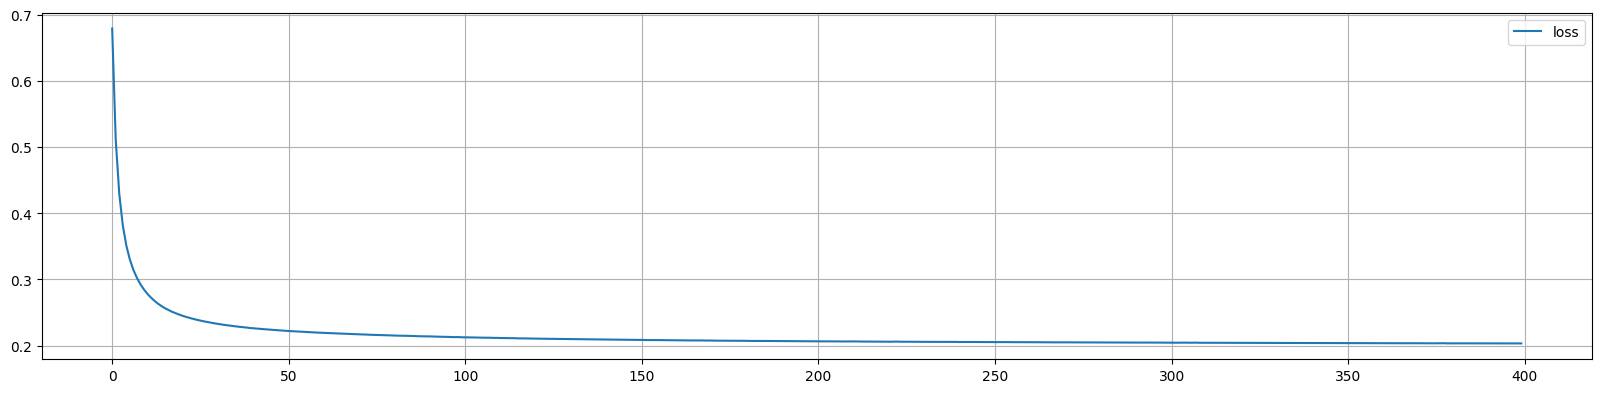

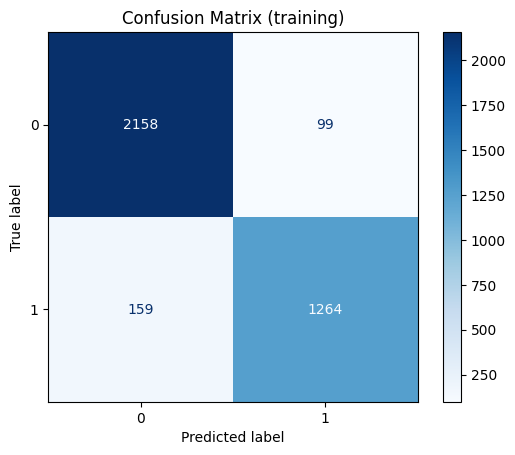

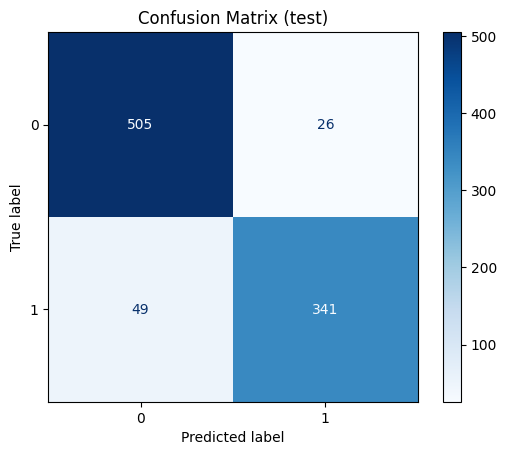

In [10]:
# Build the model
nn = build_nn_classifier(n_inputs=X_tr.shape[1], n_outputs=y_tr.shape[1], hidden=[], dropout_rate=0)

# Train the model
history = train_nn_classifier(nn, X_tr, y_tr, batch_size=32, epochs=400, verbose=0,
                              sample_weight=sample_weight_tr, validation_split=0)
history.plot(figsize=figsize, grid=':');

# Evaluate the model
eval_nn_classifier(nn, X_tr, y_tr, dataset_label='training', sample_weight=sample_weight_tr)
eval_nn_classifier(nn, X_ts, y_ts, dataset_label='test', sample_weight=sample_weight_ts)

Accuracy: 0.997 (training)
Accuracy: 0.946 (test)


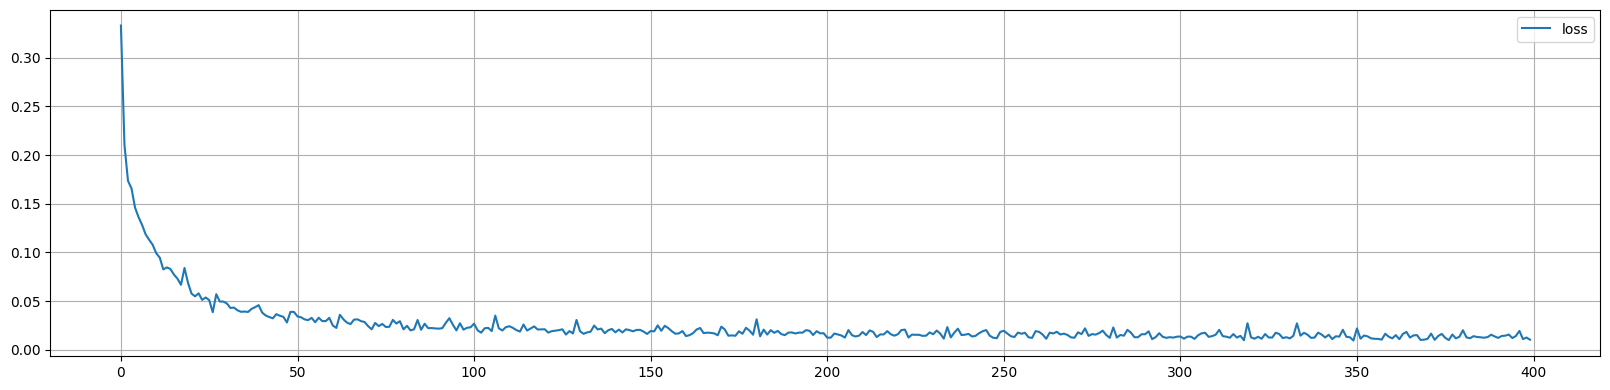

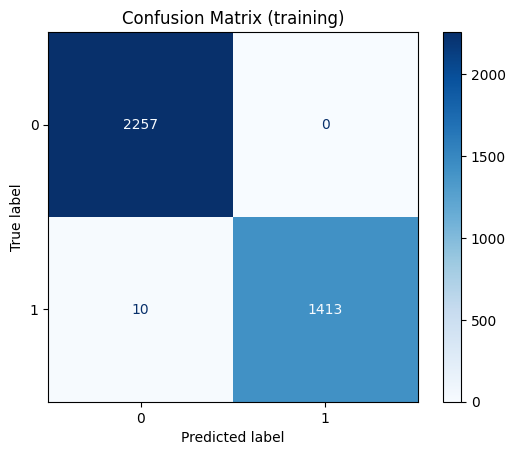

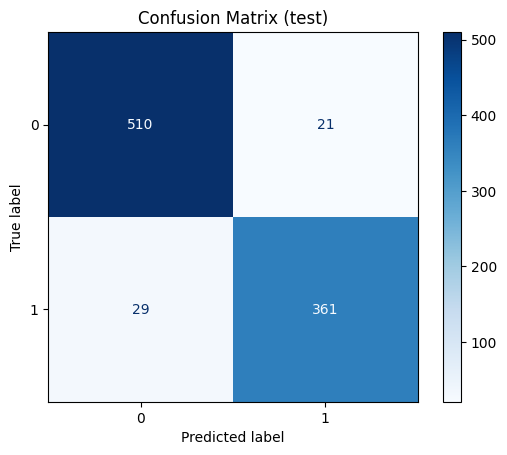

In [17]:
# Build the model
nn = build_nn_classifier(n_inputs=X_tr.shape[1], n_outputs=y_tr.shape[1], hidden=[64, 128, 64, 32], dropout_rate=0.05)

# Train the model
history = train_nn_classifier(nn, X_tr, y_tr, batch_size=32, epochs=400, verbose=0,
                              sample_weight=sample_weight_tr, validation_split=0)
history.plot(figsize=figsize, grid=':');

# Evaluate the model
eval_nn_classifier(nn, X_tr, y_tr, dataset_label='training', sample_weight=sample_weight_tr)
eval_nn_classifier(nn, X_ts, y_ts, dataset_label='test', sample_weight=sample_weight_ts)

**Try making changes and see how the results improve (or worsen)**

You can either call the functions with different parameters, or even change their code if you wish 